In [79]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [80]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [81]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [82]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


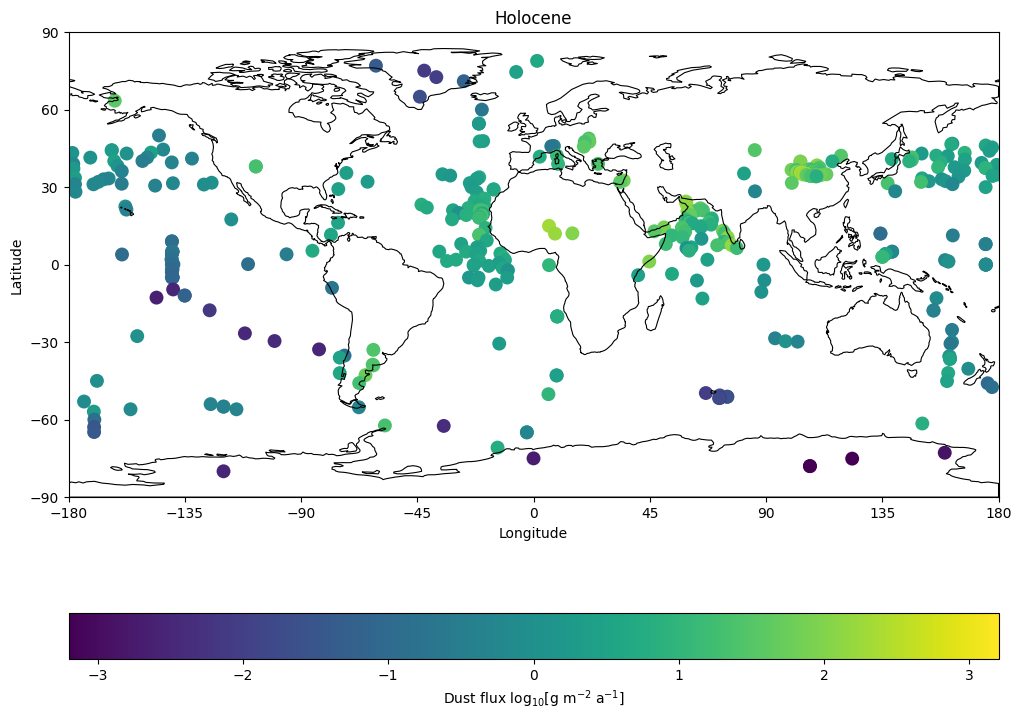

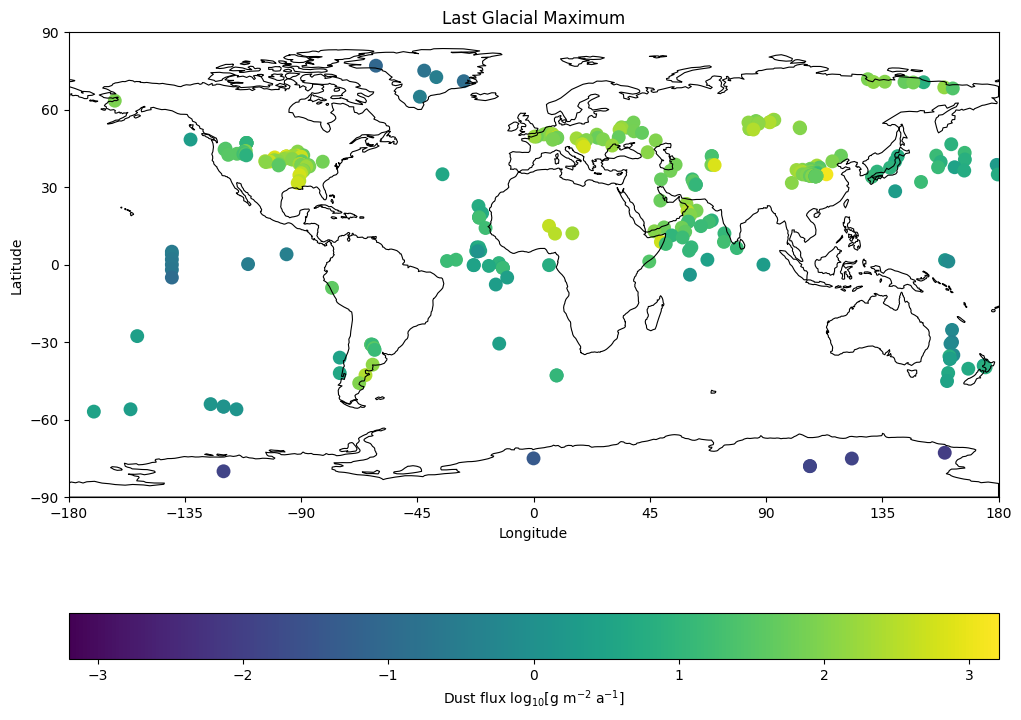

In [83]:
#Dejare esta parte del codigo comentada para que no se ejecute al correr el script,
#ya que para la entrega final no es necesario generar los mapas de los datos.

plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                          title='Last Glacial Maximum',
                          name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [84]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

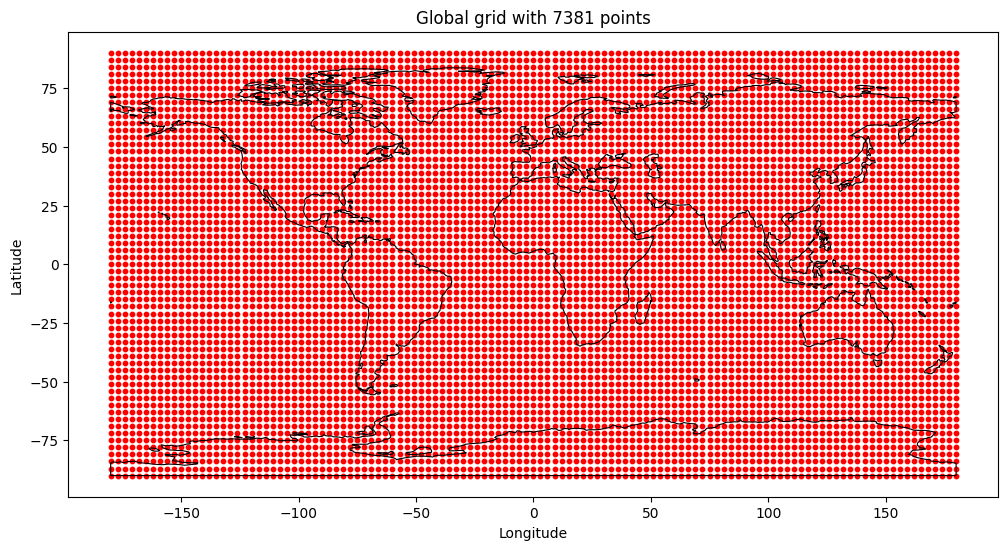

In [85]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [86]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [87]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    
    R = 6371  

    phi1 , theta1 = np.radians(x[1]) , np.radians(x[0])
    phi2 , theta2 = np.radians(y[1]) , np.radians(y[0])

    delta_phi = phi2 - phi1
    delta_theta = theta2 - theta1

    valores_arc = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_theta/2)**2
    arcos = 2 * np.arctan2(np.sqrt(valores_arc), np.sqrt(1-valores_arc))

    distance = R * arcos

    return distance

In [88]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [89]:
# n_neighbours = 3 #los cambios son muy burscos
n_neighbours = 5
# n_neighbours = 7 #Los cambios son muy suaves, pero puede causar sobreajuste

### Estimación geodésica

In [90]:
estimations_holocene_geo = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geo = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geo[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geo[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_GEO"] = estimations_holocene_geo
df_global_grid["est_lgm_GEO"] = estimations_lgm_geo

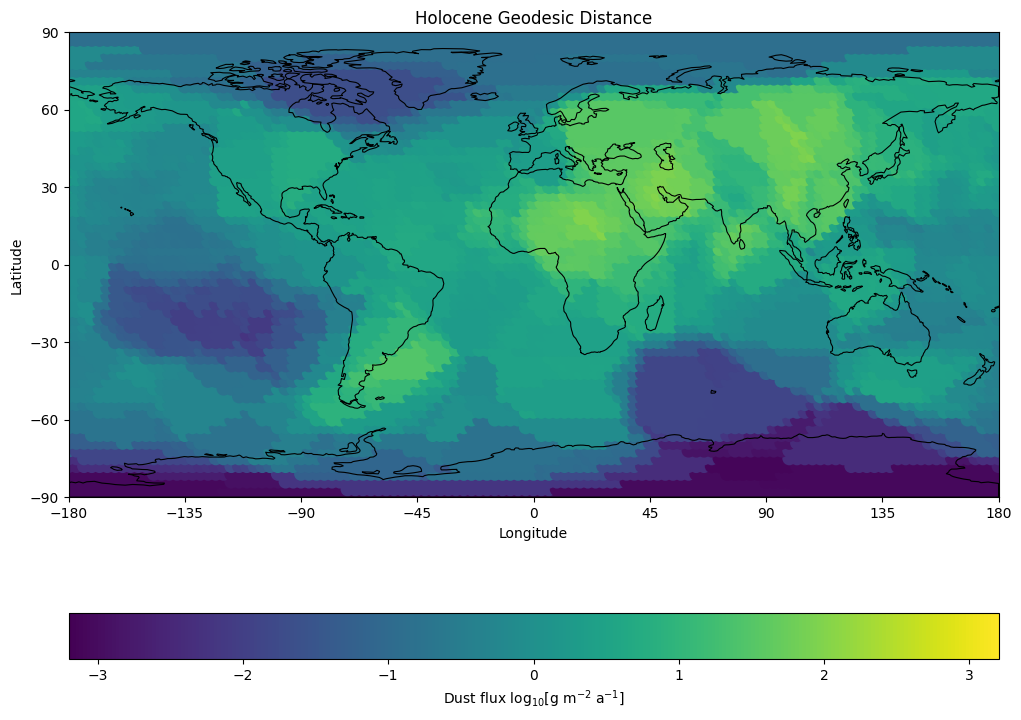

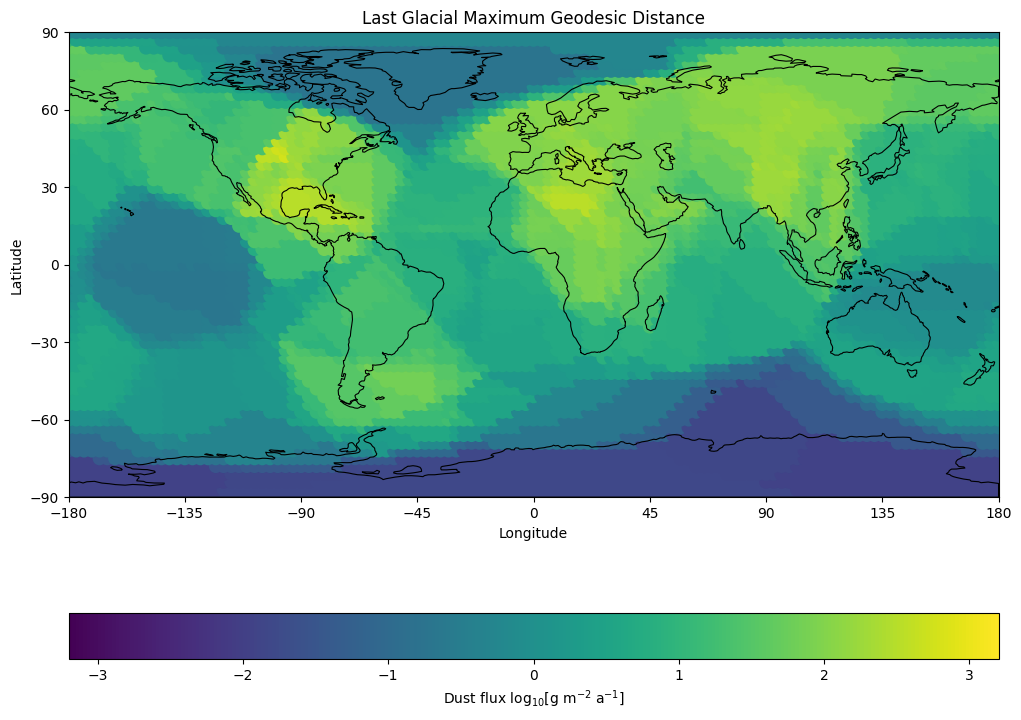

In [91]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene Geodesic Distance',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEO',
                         label_str='est_hol_GEO')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum Geodesic Distance',
                         name_to_save='ESTIMATION_MAP_LGM_GEO',
                         label_str='est_lgm_GEO')

### Estimación euclidiana

In [92]:
estimations_holocene_EU = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_EU = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_EU[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm_EU[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol_EU"] = estimations_holocene_EU
df_global_grid["est_lgm_EU"] = estimations_lgm_EU

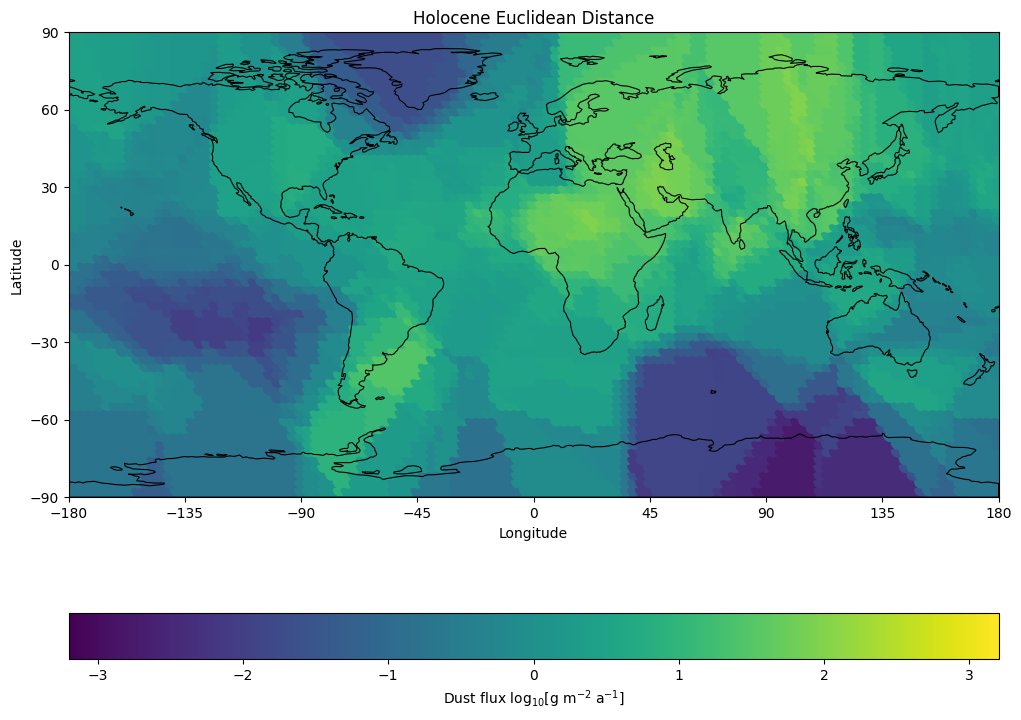

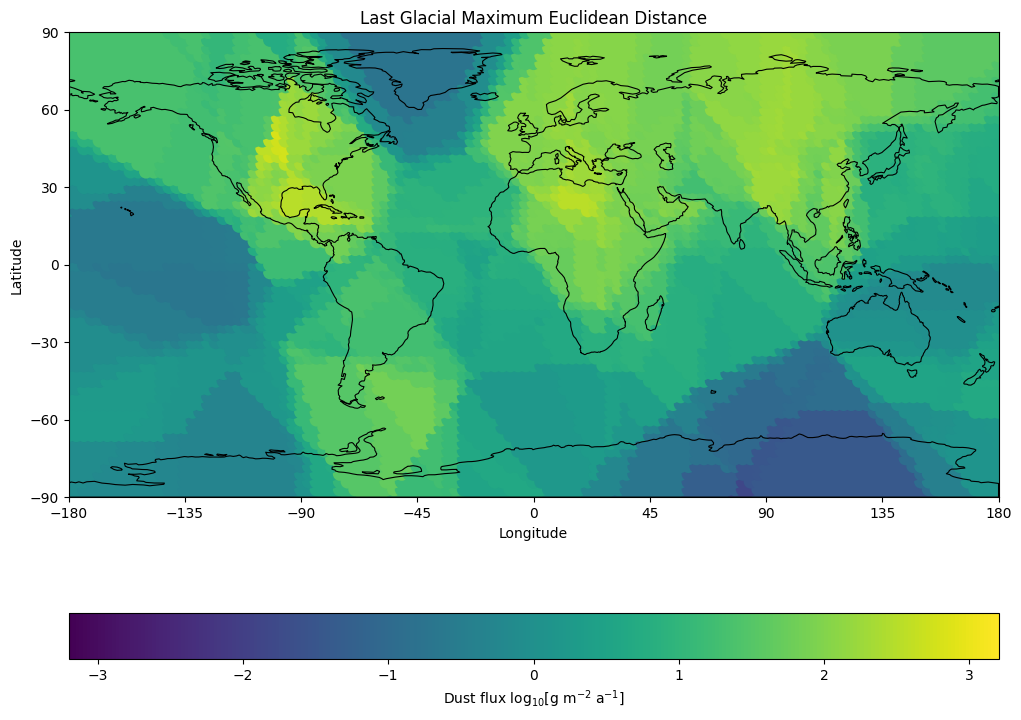

In [93]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene Euclidean Distance',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_EU',
                         label_str='est_hol_EU')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum Euclidean Distance',
                         name_to_save='ESTIMATION_MAP_LGM_EU',
                         label_str='est_lgm_EU')

In [94]:
df_global_grid['diferencia_hol'] = abs(df_global_grid['est_hol_GEO'] - df_global_grid['est_hol_EU'])
df_global_grid['diferencia_lgm'] = abs(df_global_grid['est_lgm_GEO'] - df_global_grid['est_lgm_EU'])

In [95]:
df_global_grid

,lon,lat,est_hol_GEO,est_lgm_GEO,geometry,est_hol_EU,est_lgm_EU,diferencia_hol,diferencia_lgm
0,-180.0,-90.0,-3.034526,-1.804872,POINT (-180.00000 -90.00000),-0.736623,-0.111441,2.297903,1.693431
1,-177.0,-90.0,-3.034526,-1.804872,POINT (-177.00000 -90.00000),-0.736623,-0.111441,2.297903,1.693431
2,-174.0,-90.0,-3.034526,-1.804872,POINT (-174.00000 -90.00000),-0.736623,-0.175193,2.297903,1.629679
3,-171.0,-90.0,-3.034526,-1.804872,POINT (-171.00000 -90.00000),-0.736623,-0.175193,2.297903,1.629679
4,-168.0,-90.0,-3.034526,-1.804872,POINT (-168.00000 -90.00000),-0.740268,-0.175193,2.294258,1.629679
...,...,...,...,...,...,...,...,...,...
7376,168.0,90.0,-0.889438,-0.272050,POINT (168.00000 90.00000),0.388114,1.583464,1.277551,1.855513
7377,171.0,90.0,-0.889438,-0.272050,POINT (171.00000 90.00000),0.388114,1.583464,1.277551,1.855513
7378,174.0,90.0,-0.889438,-0.272050,POINT (174.00000 90.00000),0.388114,1.583464,1.277551,1.855513
7379,177.0,90.0,-0.889438,-0.272050,POINT (177.00000 90.00000),0.388114,1.583464,1.277551,1.855513


en el siguente graficos se veran los resultados de la estimación de la tasa de deposición de polvo en la superficie terrestre, utilizando la diferencia entre distancia geodésica y la distancia euclidiana.

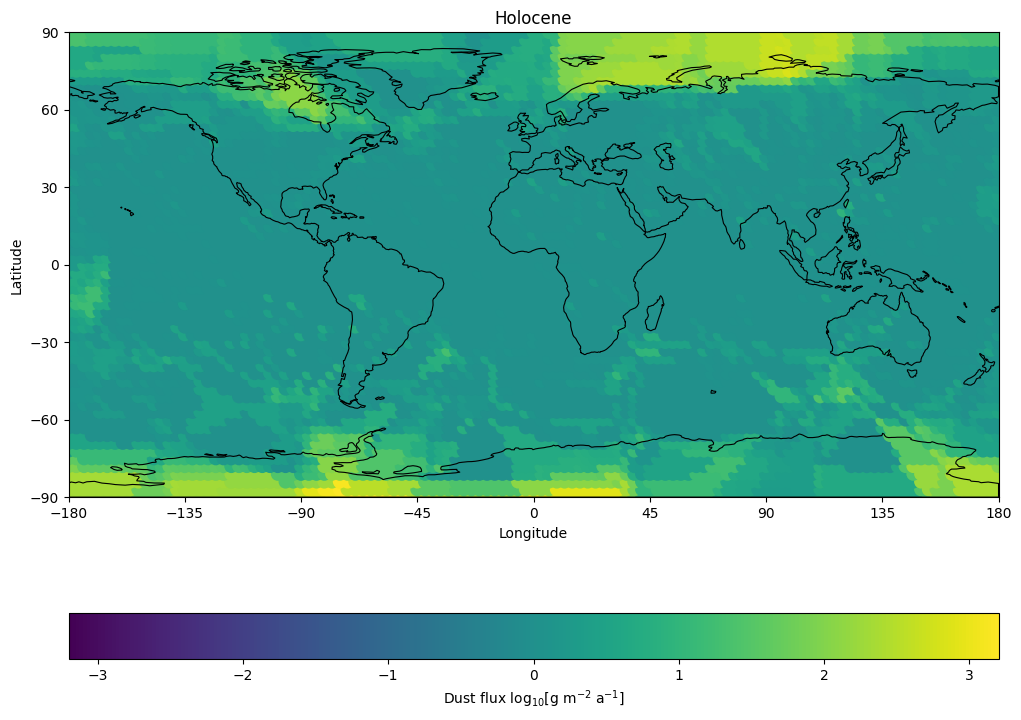

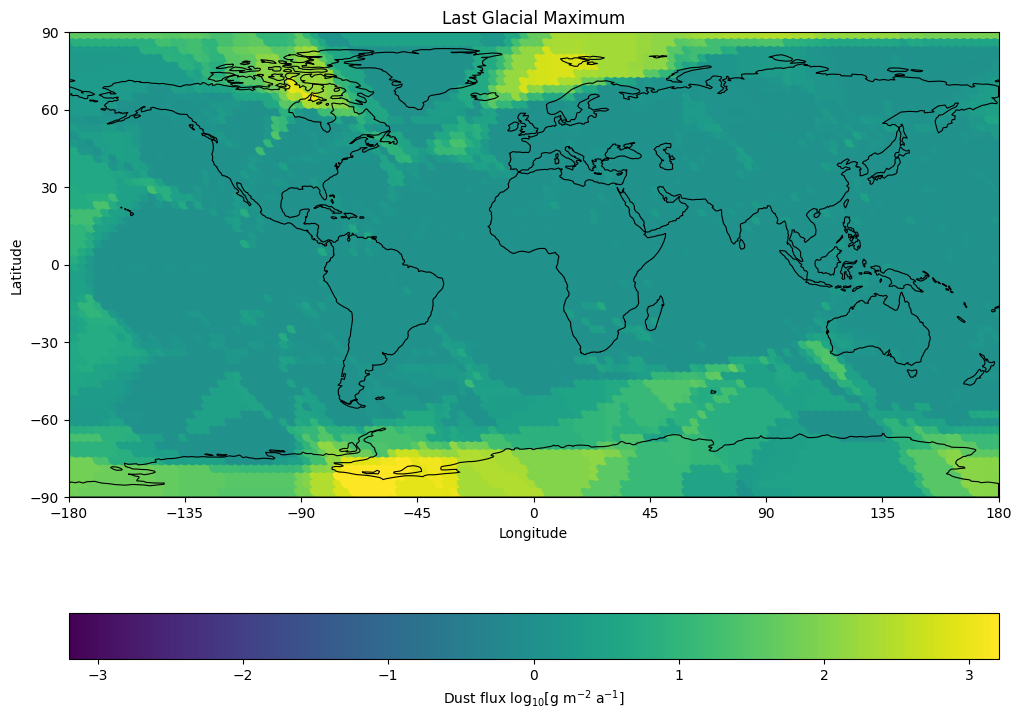

In [96]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_EU',
                         label_str='diferencia_hol')


plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_EU',
                         label_str='diferencia_lgm')

poedmos ver que donde mas existe una diferencia es en los polos, ya que la distancia geodésica es la que mejor se ajusta a la realidad de la curvatura de la tirra.

##### *a) ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?*

Esto se puede deber a los espacios geograficos de la tierra, por los cambios topologicos, por cambios en el clima de lugar, actividad, entre otros factores son los que pueden influir en la cantidad de polvo que se deposita en un lugar.
De echo se puede ver como en zonas terrestres el grafico muestra zonas mas amarillas, es decir con mas polvo, y en zonas marinas se ve mas azul, es decir con menos polvo.

##### *b) ¿Cuál método es más fidedigno en los polos sur y norte?*

Se puede ver a mi parecer de forma clara que el método de estimación geodésica es más fidedigno en los polos sur y norte, se llega a notar como al utilizar distancia euclidiana  existen cambios muy bruscos en los polos, mientras que al usar la estimación geodésica estos cambios son más suaves y si tenemos en cuenta que los polos son "un punto" no una linea, esto último hace mas sentido.

Por otra parte debemos tener en cuenta que la distancia euclidiana calcula distancias rectas, es decir no considera la curvatura de la tierra.

##### *c) ¿Cuál método es más fidedigno en longitud 180°?*

Al igual que en los polos, la estimación geodésica es más fidedigna en longitud 180°, esto se puede ver al notar que la estimación euclidiana tiene cambios muy bruscos en la zona de longitud 180°, mientras que la estimación geodésica tiene cambios más suaves.

##### *d) ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?*

Se ven diferencias en la cantidad de polvo depositado en la superficie terrestre, en el Holoceno se ve una menor cantidad de polvo depositado en la superficie terrestre, mientras que en el LGM se ve una mayor cantidad de polvo depositado en la superficie terrestre.

##### *e) ¿Cómo elegir el número de vecinos cercanos?*

Para elegir el número de vecinos cercanos se puede hacer uso de la validación cruzada, esto nos permitirá encontrar el número de vecinos que mejor se ajuste a los datos. Debido a que elegir mas de los necesarios puede llevar a un sobreajuste y elegir menos de los necesarios puede llevar a un subajuste.